In [1]:
# Class dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Other analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


### Progress
6/14/24
5.5 hours
Parameter tuned
Got rid of the - np.eye(self.d) in the gaussian step
added the dimensionality fix by adding trace to the loss (subtract the identity)
Added spiral shape
Made animation
Showed that when validation set decreases, it actually still looks okay
Experimented with differnt deliberate covariance shapes, on the spiral it works well at different positions (fixes gaps if its the right spot, but if wrong spot makes it worse. This shows that the variable covariance matrix would work well on the spiral)

Next: 

6/16/24
5 hours
Parameter tuned
built bfgs and sgd

Next:
do other speed ups
sanity checks (the big O should line up for increasing sample size)
check re randomizing


Try limiting W to be less parameterized 



In [2]:
class model3():
    def __init__(self, max_iter=1000, tol=1e-8, learning_rate=0.01, reg = 10, dim_reg = 0, optimizer = "grad", batch_size=32, epochs = 100):
        # Hyperparameters
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.reg = reg
        self.dim_reg = dim_reg

        # Variables to store
        self.X = None
        self.y = None
        self.n = None
        self.d = None
        self.weights = None
        self.classes = None
        self.num_classes = None
        self.y_dict = None
        self.one_hot = None
        self.differences = None
        self.cur_gaussian = None
        self.cur_tensor_prod = None
        self.subset_differences = []

        # Validation variables
        self.X_val_set = None
        self.y_val_set = None
        self.class_index = []
        self.val_history = []
        self.train_history = []
        self.weights_history = []
        

    ############################## Helper Functions ###############################
    def label_from_stationary(self, stationary, show_probabilities = False):
        """Get the label from the stationary distribution
        Input:
            stationary (n,) ndarray - The stationary distribution of the data
        Output:
            labels (n,) ndarray - The predicted labels of the data"""
        
        # Check if the sum of the stationary distribution is approximately 1
        if not np.isclose(np.sum(stationary), 1):
            raise ValueError("The weights do not sum to 1.")
        
        # Sum the weights for each class
        class_probabilities = np.zeros(self.num_classes)
        for weight, label in zip(stationary, self.y):
            class_probabilities[self.y_dict[label]] += weight

        # Return the probabilities if requested
        if show_probabilities:
            return class_probabilities
        
        # Otherwise, return the class with the highest weight
        else:
            indices = np.argmax(class_probabilities)
            return self.classes[indices]


    def encode_y(self,y):
        # Check if the input is a list
        if isinstance(y, list):
            y = np.array(y)

        # Make sure it is a numpy array
        elif not isinstance(y, np.ndarray):
            raise ValueError("y must be a list or a numpy array")
        
        # If it is not integers, give it a dictionary
        if y.dtype != int:
            self.classes = np.unique(y)
            self.num_classes = len(self.classes)
            self.y_dict = {label: i for i, label in enumerate(np.unique(y))}

        # If it is, still make it a dictionary
        else:
            self.classes = np.arange(np.max(y)+1)
            self.num_classes = len(self.classes)
            self.y_dict = {i: i for i in self.classes}

        # Create an index array
        for i in range(self.num_classes):
            self.class_index.append(np.where(y == self.classes[i])[0])

        # Make a one hot encoding
        self.one_hot = np.zeros((self.n, self.num_classes))
        for i in range(self.n):
            self.one_hot[i, self.y_dict[y[i]]] = 1

        
    def randomize_batches(self):
        # Get randomized indices and calculate the number of batches
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        num_batches = self.n // self.batch_size

        # Loop through the different batches and get the batches
        batches = [indices[i*self.batch_size:(i+1)*self.batch_size].tolist() for i in range(num_batches)]

        # Handle the remaining points
        remaining_points = indices[num_batches*self.batch_size:]
        counter = len(remaining_points)
        i = 0

        # Fill the remaining points into the batches
        while counter > 0:
            batches[i % len(batches)].append(remaining_points[i])
            i += 1
            counter -= 1

        # Return the batches
        return batches


    ############################## Training Calculations ##############################
    def update_differences(self, X, batches = None):
        """ Get the differences array for the informative points
        Input:
            informative_points (n,d) ndarray - The informative points
        Output:
            differences (n,n,d) ndarray - The differences array for the informative points"""
        # If it is not a batch, calculate the differences
        if batches is None:
            self.differences = X[:,np.newaxis,:] - X[np.newaxis,:,:]
        
        # Otherwise, calculate the differences for each batch
        else:
            self.subset_differences = [X[batch][:,np.newaxis,:] - X[batch][np.newaxis,:,:] for batch in batches]

    
    def update_gaussian(self, weights, subset_num = None):
        """ Get the gaussian kernel for the informative points
        Input:
            informative_points (n,d) ndarray - The informative points
            target (n,) ndarray - The target values
            weights (d,) ndarray - The weights for the informative points
        Output:
            gaussian (n,n) ndarray - The gaussian kernel for the informative points"""
        # If there is no subset, let the differences be the self.differeces
        if subset_num is None:
            differences = self.differences
        else:
            differences = self.subset_differences[subset_num]

        # Calculate the gaussian kernel and the tensor product, and save them
        tensor_prod = np.einsum('ijk,lk->ijl', differences, weights)
        self.cur_gaussian = np.exp(-np.linalg.norm(tensor_prod, axis=2)).T
        self.cur_tensor_prod = tensor_prod


    def gradient(self, W, subset = None, subset_num = None):
        # Initialize the gradient
        self.update_gaussian(W, subset_num)
        dW = np.zeros((self.d,self.d))
        differences = self.differences if subset is None else self.subset_differences[subset_num]

        # If there is no subset, let the differences be the self.differeces and the one hot be the self.one_hot
        if subset is None:
            y_index = self.class_index
            one_hot = self.one_hot
        
        # Otherwise, select the subset
        else:
            y_index = []
            y_sub = self.y[subset]

            # Loop through the different classes and select the right subsets
            for i in range(self.num_classes):
                y_index.append(np.where(y_sub == self.classes[i])[0])

            # Modify the one hot encoding to just the subset
            one_hot = np.zeros((len(subset), self.num_classes))
            for i in range(len(subset)):
                one_hot[i, self.y_dict[y_sub[i]]] = 1

        # Loop through the different classes and select the right subsets
        for i in range(len(self.classes)):
            g_c = self.cur_gaussian[y_index[i]]
            g_c_totals = np.sum(g_c, axis=0)[:, np.newaxis, np.newaxis] + 1e-20
            product_c = self.cur_tensor_prod[y_index[i]]
            differences_c = differences[y_index[i]]

            # Calculate the weighted products
            weighted_product_c = g_c[:,:,np.newaxis] * product_c
            weighted_sum_c = np.sum(np.einsum('ijk,ijl->ijkl', weighted_product_c, differences_c), axis = 0)
            weighted_sum_c /= g_c_totals

            # Calculate the gradient first term
            dW += np.sum(one_hot[:,i][:,np.newaxis, np.newaxis] * weighted_sum_c, axis=0)

        # Calculate the gradient first term
        g_all_totals = np.sum(self.cur_gaussian, axis=0)[:, np.newaxis, np.newaxis] + 1e-20
        weighted_product_all = self.cur_gaussian[:,:,np.newaxis] * self.cur_tensor_prod
        weighted_sum_all = np.sum(np.einsum('ijk,ijl->ijkl', weighted_product_all, differences), axis = 0)
        weighted_sum_all /= g_all_totals

        # Calculate the gradient second term
        dW -= np.sum(weighted_sum_all, axis=0)

        # Return the regularized gradient
        return 2*dW + self.reg*(W / np.linalg.norm(W, 'fro') - self.dim_reg*np.eye(self.d) /self.d)
    

    def loss(self, W, subset = None, subset_num = None):
        # Initialize the loss and total gaussian
        self.update_gaussian(W, subset_num)
        loss = 0
        total_g_log = np.log(np.sum(self.cur_gaussian, axis=0) + 1e-20)

        # Get the right y index
        if subset is None:
            y_index = self.class_index
        else:
            y_index = []
            for i in range(self.num_classes): # For each class
                y_index.append(np.where(self.y[subset] == self.classes[i])[0]) # Get the indices of the class within the subset
        
        # Loop through the different classes and select the right subsets
        for i in range(len(self.classes)):
            g_c = self.cur_gaussian[y_index[i]]
            loss += np.log(np.sum(g_c, axis=0) + 1e-20)

        # Calculate the loss
        loss = np.sum(loss - total_g_log) + self.reg*(np.linalg.norm(W, 'fro') - self.dim_reg*np.trace(W) /self.d)
        return loss


    ########################## Optimization and Training Functions ############################
    def gradient_descent(self):
        show_iter = max(self.max_iter,100) // 100
        for i in range(self.max_iter):
            # Get the gradient
            gradient = self.gradient(self.weights)
            self.weights -= self.learning_rate * gradient
            self.weights_history.append(self.weights.copy())

            # If there is a validation set, check the validation error
            if self.X_val_set is not None and self.y_val_set is not None:
                
                # Predict on the validation set and append the history
                val_predictions = self.predict(self.X_val_set)
                val_accuracy = accuracy_score(self.y_val_set, val_predictions)
                self.val_history.append(val_accuracy)

                # Predict on the training set and append the history
                train_predictions = self.predict(self.X)
                train_accuracy = accuracy_score(self.y, train_predictions)
                self.train_history.append(train_accuracy)
                
                # Show the progress
                if i % show_iter == 0:
                    print(f"({i}) Val Accuracy: {np.round(val_accuracy,5)}.   Train Accuracy: {train_accuracy}")

            # Check for convergence after a certain number of iterations
            break_value = np.linalg.norm(gradient)
            if break_value < self.tol*self.n and i > self.max_iter//50:
                break


    def stochastic_gradient_descent(self, re_randomize = False):
        # Raise an error if there are no epochs or batch size, or if batch size is greater than the number of points
        if self.batch_size is None or self.epochs is None:
            raise ValueError("Batch size or epochs must be specified")
        if self.batch_size > self.n:
            raise ValueError("Batch size must be less than the number of points")
        
        # Initialize the loop, get the batches, and go through the epochs
        batches = self.randomize_batches()
        loop = tqdm(total=self.epochs*len(batches), position=0)
        self.update_differences(self.X, batches)
        for epoch in range(self.epochs):

            # reset the batches if re_randomize is true
            if re_randomize and epoch > 0:
                batches = self.randomize_batches()
                self.update_differences(self.X, batches)
            
            # Loop through the different batches
            loss_list = []
            self.weights_history.append(self.weights.copy())
            for i, batch in enumerate(batches):

                # Get the gradient, update weights, and append the loss
                gradient = self.gradient(self.weights, subset = batch, subset_num = i)
                self.weights -= self.learning_rate * gradient
                loss_list.append(self.loss(self.weights, subset = batch, subset_num = i))

                # update our loop
                loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss_list[-1]))
                loop.update()

            # If there is a validation set, check the validation error
            if self.X_val_set is not None and self.y_val_set is not None:
                
                # Predict on the validation set and append the history
                val_predictions = self.predict(self.X_val_set)
                val_accuracy = accuracy_score(self.y_val_set, val_predictions)
                self.val_history.append(val_accuracy)

                # Predict on the training set and append the history
                train_predictions = self.predict(self.X)
                train_accuracy = accuracy_score(self.y, train_predictions)
                self.train_history.append(train_accuracy)
                
                # Show the progress
                # print(f"({epoch}) Val Accuracy: {np.round(val_accuracy,5)}.   Train Accuracy: {train_accuracy}")

            # Append the history of the weights
            self.weights_history.append(self.weights.copy())
            
        # Close the loop
        loop.close()


    def bfgs(self):
        # Define iterations to show the progress and define the loss and gradient function in 1D
        show_iter = max(self.max_iter, 100) // 100
        loss_bfgs = lambda W: self.loss(W.reshape(self.d, self.d))
        gradient_bfgs = lambda W: self.gradient(W.reshape(self.d, self.d)).flatten()

        # Define the callback function
        def callback(weights):
            self.weights = weights.reshape(self.d, self.d)
            self.weights_history.append(self.weights.copy())

            # If there is a validation set, check the validation error
            if self.X_val_set is not None and self.y_val_set is not None:
                val_predictions = self.predict(self.X_val_set)
                val_accuracy = accuracy_score(self.y_val_set, val_predictions)
                self.val_history.append(val_accuracy)
                
                # Predict on the validation set and append the history
                train_predictions = self.predict(self.X)
                train_accuracy = accuracy_score(self.y, train_predictions)
                self.train_history.append(train_accuracy)

                # Show the progress
                if len(self.weights_history) % show_iter == 0:
                    print(f"({len(self.weights_history)}) Val Accuracy: {np.round(val_accuracy, 5)}.   Train Accuracy: {train_accuracy}")
        
        # Run the optimizer
        res = minimize(loss_bfgs, self.weights.flatten(), jac=gradient_bfgs, method='BFGS', options={'disp': False, 'maxiter': self.max_iter, 'gtol':self.tol}, callback=callback)
        self.weights = res.x.reshape(self.d, self.d)

    def fit(self, X, y, X_val_set = None, y_val_set = None, init_weights = None):
        # Save the data as variables and encode y
        self.X = np.array(X)
        self.y = np.array(y)
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.encode_y(y)

        # Initialize the weights
        if init_weights is not None:
            self.weights = init_weights
        else:
            self.weights = .125*((np.random.random((self.d,self.d))*2 - 1) + np.eye(self.d))

        # If there is a validation set, save it
        if X_val_set is not None and y_val_set is not None:
            self.X_val_set = X_val_set
            self.y_val_set = y_val_set

        # Perform necessary differences calculations
        if self.optimizer != "sgd":
            self.update_differences(self.X)

        # Run the optimizer
        if self.optimizer == "sgd":
            self.stochastic_gradient_descent()
        elif self.optimizer == "bfgs":
            self.bfgs()
        elif self.optimizer == "grad":
            self.gradient_descent()

        # Otherwise, raise an error
        else:
            raise ValueError("Optimizer must be 'sgd', 'bfgs, or 'grad'")


    ############################## Prediction Functions #############################
    def predict(self, points, show_probabilities=False):
        """Predict the labels of the data
        Input:
            points (n,d) ndarray - The data to predict
        Output:
            predictions (n,) ndarray - The predicted labels of the data"""
        # Check the shape of the data and the point and initialize the predictions
        if len(points.shape) == 1:
            points = points[np.newaxis,:]
        predictions = []

        # Get the differences array
        differences = self.X[:,np.newaxis,:] - points[np.newaxis,:,:]
        probs = np.exp(-np.linalg.norm(np.einsum('ijk,lk->ijl', differences, self.weights), axis=2)).T + 1e-75
        probs /= np.sum(probs, axis=1, keepdims=True)
        
        # Loop through the different points and get the predictions
        for i in range(points.shape[0]):
            predictions.append(self.label_from_stationary(probs[i], show_probabilities=show_probabilities))

        # Return the predictions
        return np.array(predictions)


    ############################## Other Functions ###############################
    def copy(self):
        # Initialize a new model
        new_model = model3(max_iter=self.max_iter, tol=self.tol, learning_rate=self.learning_rate, reg=self.reg, dim_reg=self.dim_reg, optimizer=self.optimizer, batch_size=self.batch_size, epochs=self.epochs)
        
        # Save the attributes of the new model
        new_model.X = self.X
        new_model.y = self.y
        new_model.n = self.n
        new_model.d = self.d
        new_model.weights = self.weights
        new_model.classes = self.classes
        new_model.num_classes = self.num_classes
        new_model.y_dict = self.y_dict
        new_model.one_hot = self.one_hot
        new_model.differences = self.differences
        new_model.cur_gaussian = self.cur_gaussian
        new_model.cur_tensor_prod = self.cur_tensor_prod
        new_model.X_val_set = self.X_val_set
        new_model.y_val_set = self.y_val_set
        new_model.class_index = self.class_index
        new_model.val_history = self.val_history
        new_model.train_history = self.train_history
        new_model.weights_history = self.weights_history

        # Return the new model
        return new_model
        

### 2D plotting functions

In [3]:
def show_probs(model, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points, show_probabilities=True)[:,1]
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm, levels = 100)
    level_set = plt.contour(xx, yy, Z, levels=[0.5], colors='grey', linestyles='dashed', linewidths=.5)
    plt.clabel(level_set)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # plot a circle around the origin
    circle = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_artist(circle)
    plt.show()

    # Plot the 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, 1-Z, cmap='coolwarm')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Probability of being in class 1')
    plt.show()

def plot_boundary(model, title, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid_points)
    Z = np.array(predictions).reshape(xx.shape)

    # Plot the decision boundary using a contour plot
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # plot a circle around the origin
    circle = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_artist(circle)
    plt.show()

    predictions_y = np.linalg.norm(grid_points, axis=1)>1
    print("Coverage: ", accuracy_score(predictions, predictions_y))

def animate_boundary(model, title, h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5]):
    x_min, x_max = x_size[0], x_size[1]
    y_min, y_max = y_size[0], y_size[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Make the figure
    fig = plt.figure(figsize=(6, 6))

    def update(iter):
        print(iter)
        model_used = model.copy()
        model_used.weights = model.weights_history[iter]
        predictions = model_used.predict(grid_points)
        Z = np.array(predictions).reshape(xx.shape)
        plt.clf()
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, alpha = .5, s=10)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f" Iteration: {iter} Validation Accuracy: {model.val_history[iter]}")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        circle = plt.Circle((0, 0), 1, color='k', fill=False)
        plt.gca().add_artist(circle)
        
    ani = FuncAnimation(fig, update, frames=range(len(model.weights_history)), repeat=False)
    ani.save(title+".mp4")

def animate_weights(model, title):
    model_used = model.copy()
    # Make the figure
    fig = plt.figure(figsize=(6, 6))

    def update(iter):
        weights = model_used.weights_history[iter]
        plt.clf()
        plt.imshow(weights)
        plt.title(f" Iteration: {iter} Validation Accuracy: {model.val_history[iter]}")
        plt.colorbar()
    ani = FuncAnimation(fig, update, frames=range(len(model.weights_history)), repeat=False)
    ani.save(title+".mp4")



Sometimes it goes to a singular matrix, Still pretty good though
adding regularization helps
sometimes the accuracy improves, then with further training deteriorates, why?
subtracting out the identity difference

1. Bayesian approach try it
2. Hold off on deep learning
3. Start SGD, then move to BFGS and then double check of there is stochastic BFGS
4. Look for dimensionality preservation regularization

Dataset recommendations
mnist, fashion mnist, sipher 10
tabular data



epoch:99, loss:-283.7264: 100%|██████████| 1500/1500 [00:08<00:00, 167.88it/s]


[[ 5.78229067 -3.30462113]
 [ 3.56437487  6.23669869]]
0.892


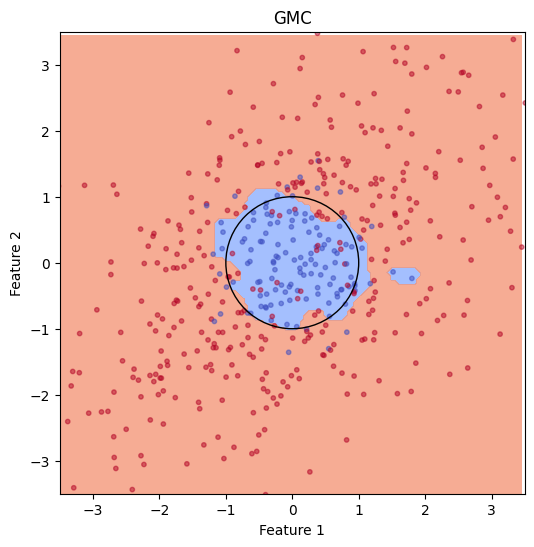

Coverage:  0.981938775510204


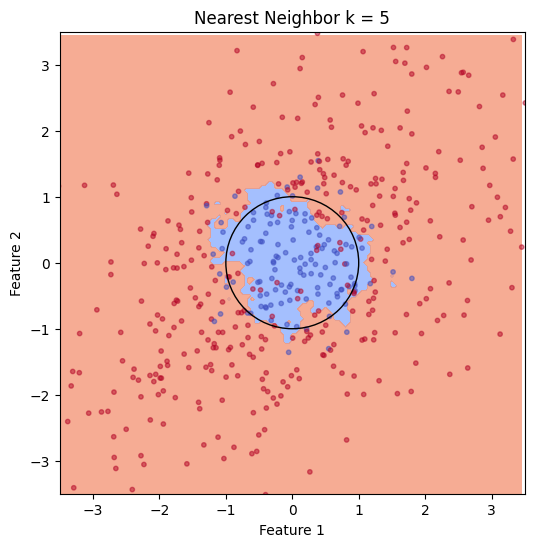

Coverage:  0.9778061224489796


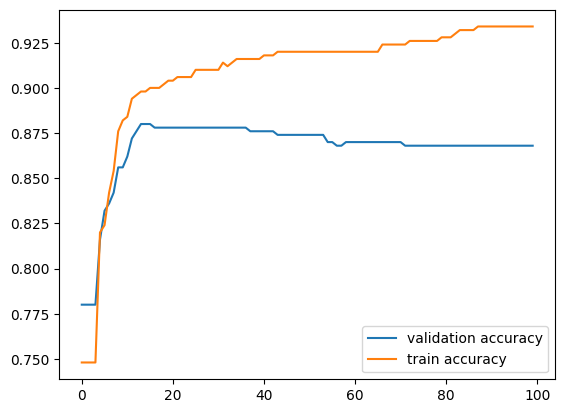

In [4]:
#np.random.seed(47)
X = np.random.multivariate_normal([0,0], np.array([[2,1],[1,2]]), 1000)
y = np.linalg.norm(X, axis=1)>1
# t = np.arange(0, 2*2*np.pi, 0.1)
# spiral = t[:,np.newaxis]*np.array([np.cos(t), np.sin(t)]).T/5
# distance = np.min(np.linalg.norm(X[:,np.newaxis,:] - spiral[np.newaxis,:,:], axis=2), axis=1)
# y = distance<.25
X += np.random.normal(0, .4, X.shape)

x_val = X[500:]
y_val = y[500:]
X = X[:500]
y = y[:500]


# plt.scatter(X[:,0], X[:,1], c=y)
# plt.plot(spiral[:,0], spiral[:,1])
# plt.show()

test = np.random.multivariate_normal([0,0], np.array([[2,1],[1,2]]), 100)
test_y = np.linalg.norm(test, axis=1)>1

model_toy = model3(learning_rate=.0025, reg = 1, dim_reg = .01, max_iter=50, optimizer="sgd", tol=1e-6)
model_toy.fit(X, y, X_val_set= x_val, y_val_set=y_val)
# print("begin prediction")
# predictions = model.predict(test)
print(model_toy.weights)
# print(accuracy_score(predictions, test_y))

# nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
neighbors = 5
knn = KNeighborsClassifier(n_neighbors= neighbors)
knn.fit(X, y)

best_prediction = np.linalg.norm(x_val, axis=1)>1
print(accuracy_score(best_prediction, y_val))

plot_boundary(model_toy, "GMC", h=.05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])
plot_boundary(knn, f"Nearest Neighbor k = {neighbors}",h = .05, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])
plt.plot(model_toy.val_history, label = "validation accuracy")
plt.plot(model_toy.train_history, label = "train accuracy")
plt.legend()
plt.show()

In [5]:
# animation.writer = animation.writers['ffmpeg']
# animate_boundary(model_toy, "GMC Spiral", h=.075, x_size = [-3.5, 3.5], y_size = [-3.5, 3.5])

In [6]:
cov_inv = model_toy.weights.T @ model_toy.weights
cov = np.linalg.inv(cov_inv)
print(cov_inv)
print(cov)
print(cov_inv[0] /cov_inv[1])

[[46.13965356  3.12165221]
 [ 3.12165221 49.81693139]]
[[ 0.02176561 -0.00136389]
 [-0.00136389  0.02015896]]
[14.78052343  0.06266247]


In [7]:
# load digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# randomly choose a subset of the data
# np.random.seed(29)
n=1000
indices = np.random.choice(X_train_val.shape[0], n, replace=False)
val_indices = np.setdiff1d(np.arange(X_train_val.shape[0]), indices)

X_train = X_train_val[indices]
y_train = y_train_val[indices]
X_val = X_train_val[val_indices]
y_val = y_train_val[val_indices]
model = model3(learning_rate=.01, reg = 1, dim_reg=.1, tol = 1e-5, optimizer="sgd", batch_size=64, epochs=20)
model.fit(X_train, y_train, X_val_set= X_train_val, y_val_set= y_train_val)

gmc_predictions = model.predict(X_test)

# nearest neighbor
neighbors = 2
knn = KNeighborsClassifier(n_neighbors= neighbors)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

epoch:19, loss:-8909.5340: 100%|██████████| 300/300 [01:10<00:00,  4.27it/s] 


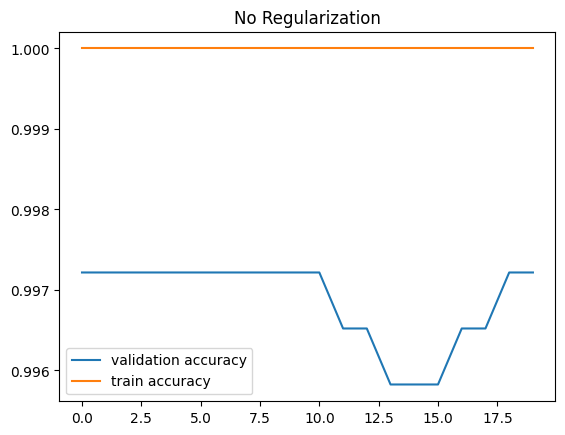

GMC Accuracy: 0.9861111111111112
KNN Accuracy: 0.975
Random Forest Accuracy: 0.9805555555555555


In [10]:
plt.title("No Regularization")
plt.plot(model.val_history, label = "validation accuracy")
plt.plot(model.train_history, label = "train accuracy")
plt.legend()
plt.show()

model.weights = model.weights_history[-1]

gmc_predictions = model.predict(X_test)


# import random forest and xgboost for benchmarking
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

# # xgboost
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# xgb_predictions = xgb.predict(X_test)


print("GMC Accuracy:",accuracy_score(gmc_predictions, y_test))
print("KNN Accuracy:",accuracy_score(knn_predictions, y_test))
print("Random Forest Accuracy:", accuracy_score(rf_predictions, y_test))
#print("XGBoost Accuracy:", accuracy_score(xgb_predictions, y_test))


# # confusion matrix
# confusion_matrix(y_test, gmc_predictions)
# confusion_matrix(y_test, knn_predictions)
# confusion_matrix(y_test, xgb_predictions)
# confusion_matrix(y_test, rf_predictions)

In [11]:
model_reg = model3(learning_rate=.2, reg = 0, optimizer="grad", max_iter=1000)
model_reg.fit(X_train, y_train, X_val_set= X_train_val, y_val_set= y_train_val)
gmc_predictions_reg = model_reg.predict(X_test)

(0) Val Accuracy: 0.99513.   Train Accuracy: 1.0
(10) Val Accuracy: 0.99652.   Train Accuracy: 1.0
(20) Val Accuracy: 0.99652.   Train Accuracy: 1.0


KeyboardInterrupt: 

In [ ]:
iter = 0
model_reg.weights = model_reg.weights_history[iter]

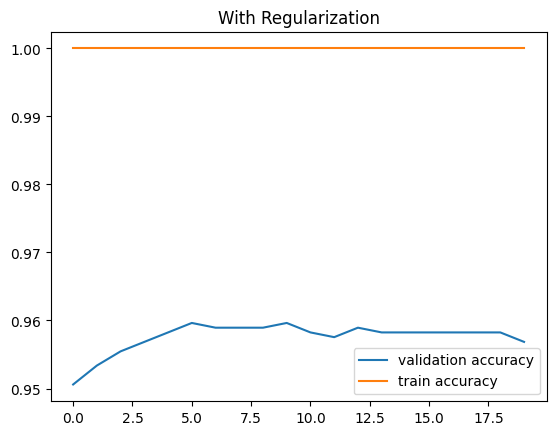

GMC Reg Accuracy: 0.9555555555555556
KNN Accuracy: 0.9361111111111111
Random Forest Accuracy: 0.9305555555555556


In [ ]:
plt.title("With Regularization")
plt.plot(model_reg.val_history, label = "validation accuracy")
plt.plot(model_reg.train_history, label = "train accuracy")
plt.legend()
plt.show()

iter = -1
model_reg.weights = model_reg.weights_history[iter]
gmc_predictions_reg = model_reg.predict(X_test)
print("GMC Reg Accuracy:",accuracy_score(gmc_predictions_reg, y_test))
print("KNN Accuracy:",accuracy_score(knn_predictions, y_test))
print("Random Forest Accuracy:", accuracy_score(rf_predictions, y_test))
#print("XGBoost Accuracy:", accuracy_score(xgb_predictions, y_test))

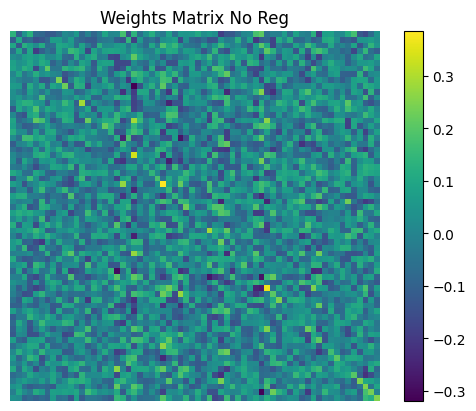

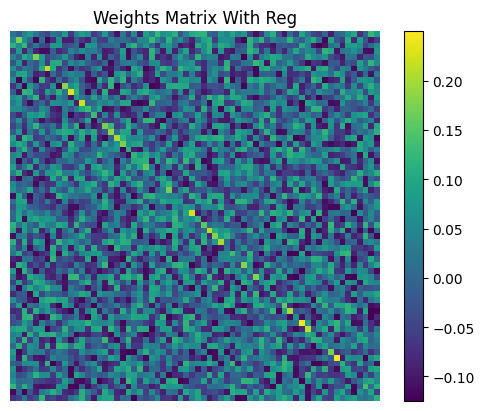

In [ ]:
weights = model_reg.weights
reg_weights = model.weights

plt.title("Weights Matrix No Reg")
plt.imshow(weights)
plt.colorbar()
plt.axis('off')
plt.show()

plt.title("Weights Matrix With Reg")
plt.imshow(reg_weights)
plt.colorbar()
plt.axis('off')
plt.show()

Rank of not reg matrix: 60
Rank of reg matrix: 60
Rank of random matrix: 61


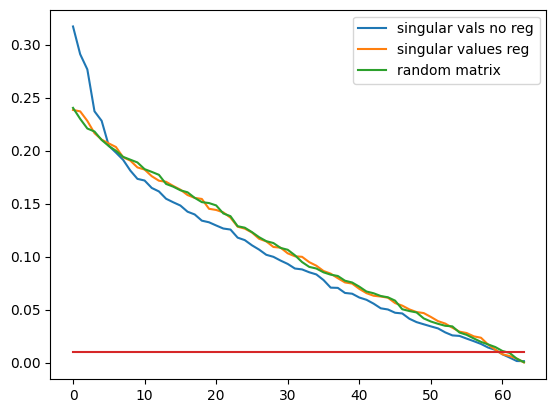

In [ ]:
lim = 1e-2
u,s,v  = np.linalg.svd(weights / np.linalg.norm(weights))
rank = np.sum(s > lim)
print("Rank of not reg matrix:", rank)

u_reg,s_reg,v_reg  = np.linalg.svd(reg_weights/ np.linalg.norm(reg_weights))
rank_reg = np.sum(s_reg > lim)
print("Rank of reg matrix:", rank_reg)

rand_mat = np.random.random((64,64))*2 - 1
rand_mat = rand_mat / np.linalg.norm(rand_mat)
u_rand, s_rand, v_rand = np.linalg.svd(rand_mat)
rank_rand = np.sum(s_rand > lim)
print("Rank of random matrix:", rank_rand)



plt.plot(s, label = "singular vals no reg")
plt.plot(s_reg, label='singular values reg')
plt.plot(s_rand, label = "random matrix")
plt.plot(np.ones(64)*lim)
plt.legend()
plt.show()

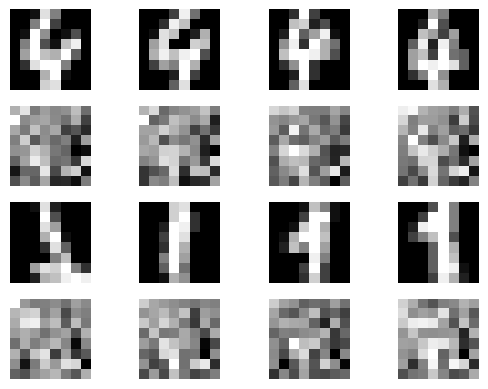

In [ ]:
# show an image of the train data
target = [4,1]
count = 4
reg = False

plt.figure()
for i,t in enumerate(target):
    index = 0
    success = 0
    while success < count:

        
        if y_train[index] == t:
            plt.subplot(2*len(target),count,2*i*count+success+1)
            plt.imshow(X_train[index].reshape(8,8), cmap='gray')
            plt.axis('off')
            plt.subplot(2*len(target),count,2*i*count+count+success+1)
            if reg == True:
                weights = model_reg.weights
            else:
                weights = model.weights
            plt.imshow((weights @ X_train[index]).reshape(8,8), cmap='gray')
            plt.axis('off')
            success += 1
        index += 1
        
plt.show()

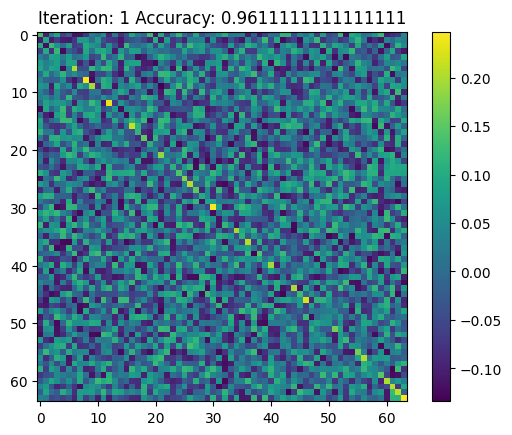

In [ ]:
iter = 1

model_copy = model_reg.copy()
model_copy.weights = model_copy.weights_history[iter]
y_preds = model_copy.predict(X_test)
accuracy = accuracy_score(y_preds, y_test)


plt.title(f"Iteration: {iter} Accuracy: {accuracy}")
plt.imshow(model_copy.weights)
plt.colorbar()
plt.show()

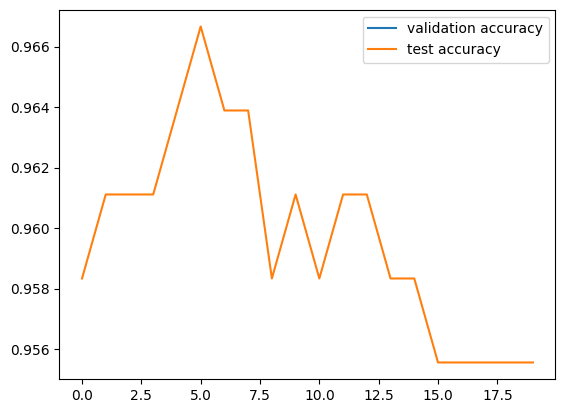

In [ ]:
model_temp = model_reg.copy()
test_score =[]
for i in range(len(model_temp.weights_history)):
    model_temp.weights = model_temp.weights_history[i]
    predictions = model_temp.predict(X_test)
    test_score.append(accuracy_score(predictions, y_test))


plt.plot(model.val_history, label = "validation accuracy")
plt.plot(test_score, label = "test accuracy")
plt.legend()
plt.show()